# Moltenprot processing
In this notebook, we'll explore Prometheus curves and automated ways to cut off messy data for input into moltenprot. Here are a few examples of what we're looking to do:

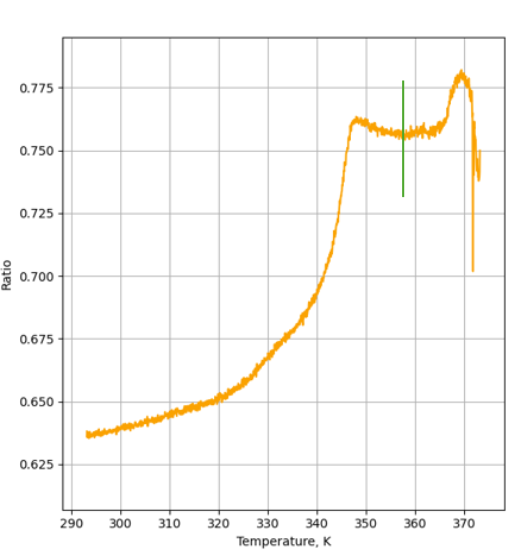

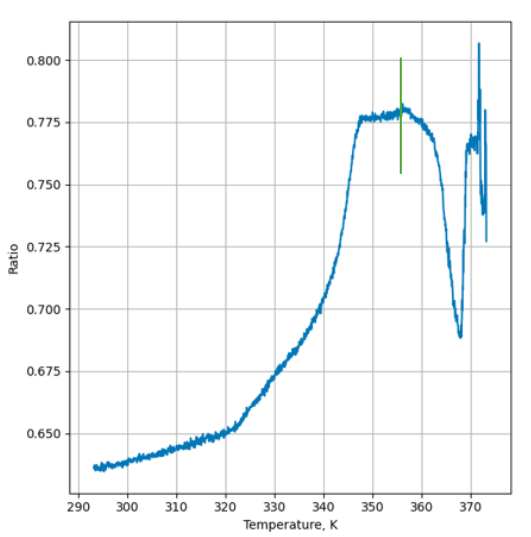

We basically want to cut the curve off after the first major inflection point, in an automated way.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read in data

In [19]:
moltenprot_dfs = pd.read_excel('../data/02-07-2025_Prometheus-processed_data-unchanged.xlsx', sheet_name=None, header=[0, 1, 2], index_col=0)

In [20]:
moltenprot_dfs['Ratio'].head()

,Capillary,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
,Sample ID,A. thaliana PGP,T. astrocarpus PGP,T. astrocarpus PGP,T. forrestii PGP,C. merolae PGP,R. stricta PGP,G. max PGP 1,C. nivalis PGP,A. thaliana PGP,...,R. stricta PGP,C. nivalis PGP,R. stricta PGP,B. rapa PGP,T. astrocarpus PGP,G. max PGP 2,G. max PGP 1,G. max PGP 2,B. rapa PGP,C. merolae PGP
Time [s],Temperature [°C],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],...,Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts],Fluorescence [counts]
4.467157,20.000000,0.699450,0.619969,0.638117,0.630510,0.628085,0.618862,0.629090,0.657062,0.711389,...,0.616273,0.662252,0.619368,0.596500,0.636430,0.566301,0.632674,0.566381,0.598350,0.630863
22.580621,20.046893,0.710157,0.629800,0.635743,0.629380,0.631977,0.615571,0.630464,0.657030,0.710242,...,0.617061,0.661470,0.619664,0.596585,0.636429,0.566711,0.632637,0.566102,0.597270,0.631083
31.388756,20.093787,0.709514,0.628742,0.637123,0.630563,0.631044,0.617287,0.631045,0.657228,0.708761,...,0.616636,0.660742,0.618574,0.595988,0.635642,0.566944,0.634070,0.565564,0.598100,0.630965
37.952540,20.140680,0.711045,0.629255,0.637816,0.629057,0.632294,0.615918,0.630336,0.657987,0.709760,...,0.615739,0.660356,0.619455,0.595691,0.637296,0.566584,0.632610,0.565654,0.597371,0.630130
43.777285,20.187573,0.711486,0.629076,0.636138,0.628529,0.630401,0.614381,0.630537,0.659142,0.709743,...,0.616672,0.661864,0.619130,0.596150,0.635903,0.566992,0.632793,0.566121,0.597456,0.631242


## Explore available information from Prometheus
It looks like Prometheus gives us the first derivative of all of the curves; let's plot these with the curves themselves.

In [21]:
def close_factors(number):
    ''' 
    find the closest pair of factors for a given number

    from: https://stackoverflow.com/questions/67051401/how-to-automatically-set-number-of-rows-columns-subplots
    '''
    factor1 = 0
    factor2 = number
    while factor1 +1 <= factor2:
        factor1 += 1
        if number % factor1 == 0:
            factor2 = number // factor1
        
    return factor1, factor2


def almost_factors(number):
    '''
    find a pair of factors that are close enough for a number that is close enough

    from: https://stackoverflow.com/questions/67051401/how-to-automatically-set-number-of-rows-columns-subplots
    '''
    while True:
        factor1, factor2 = close_factors(number)
        if 1/2 * factor1 <= factor2: # the fraction in this line can be adjusted to change the threshold aspect ratio
            break
        number += 1
    return factor1, factor2

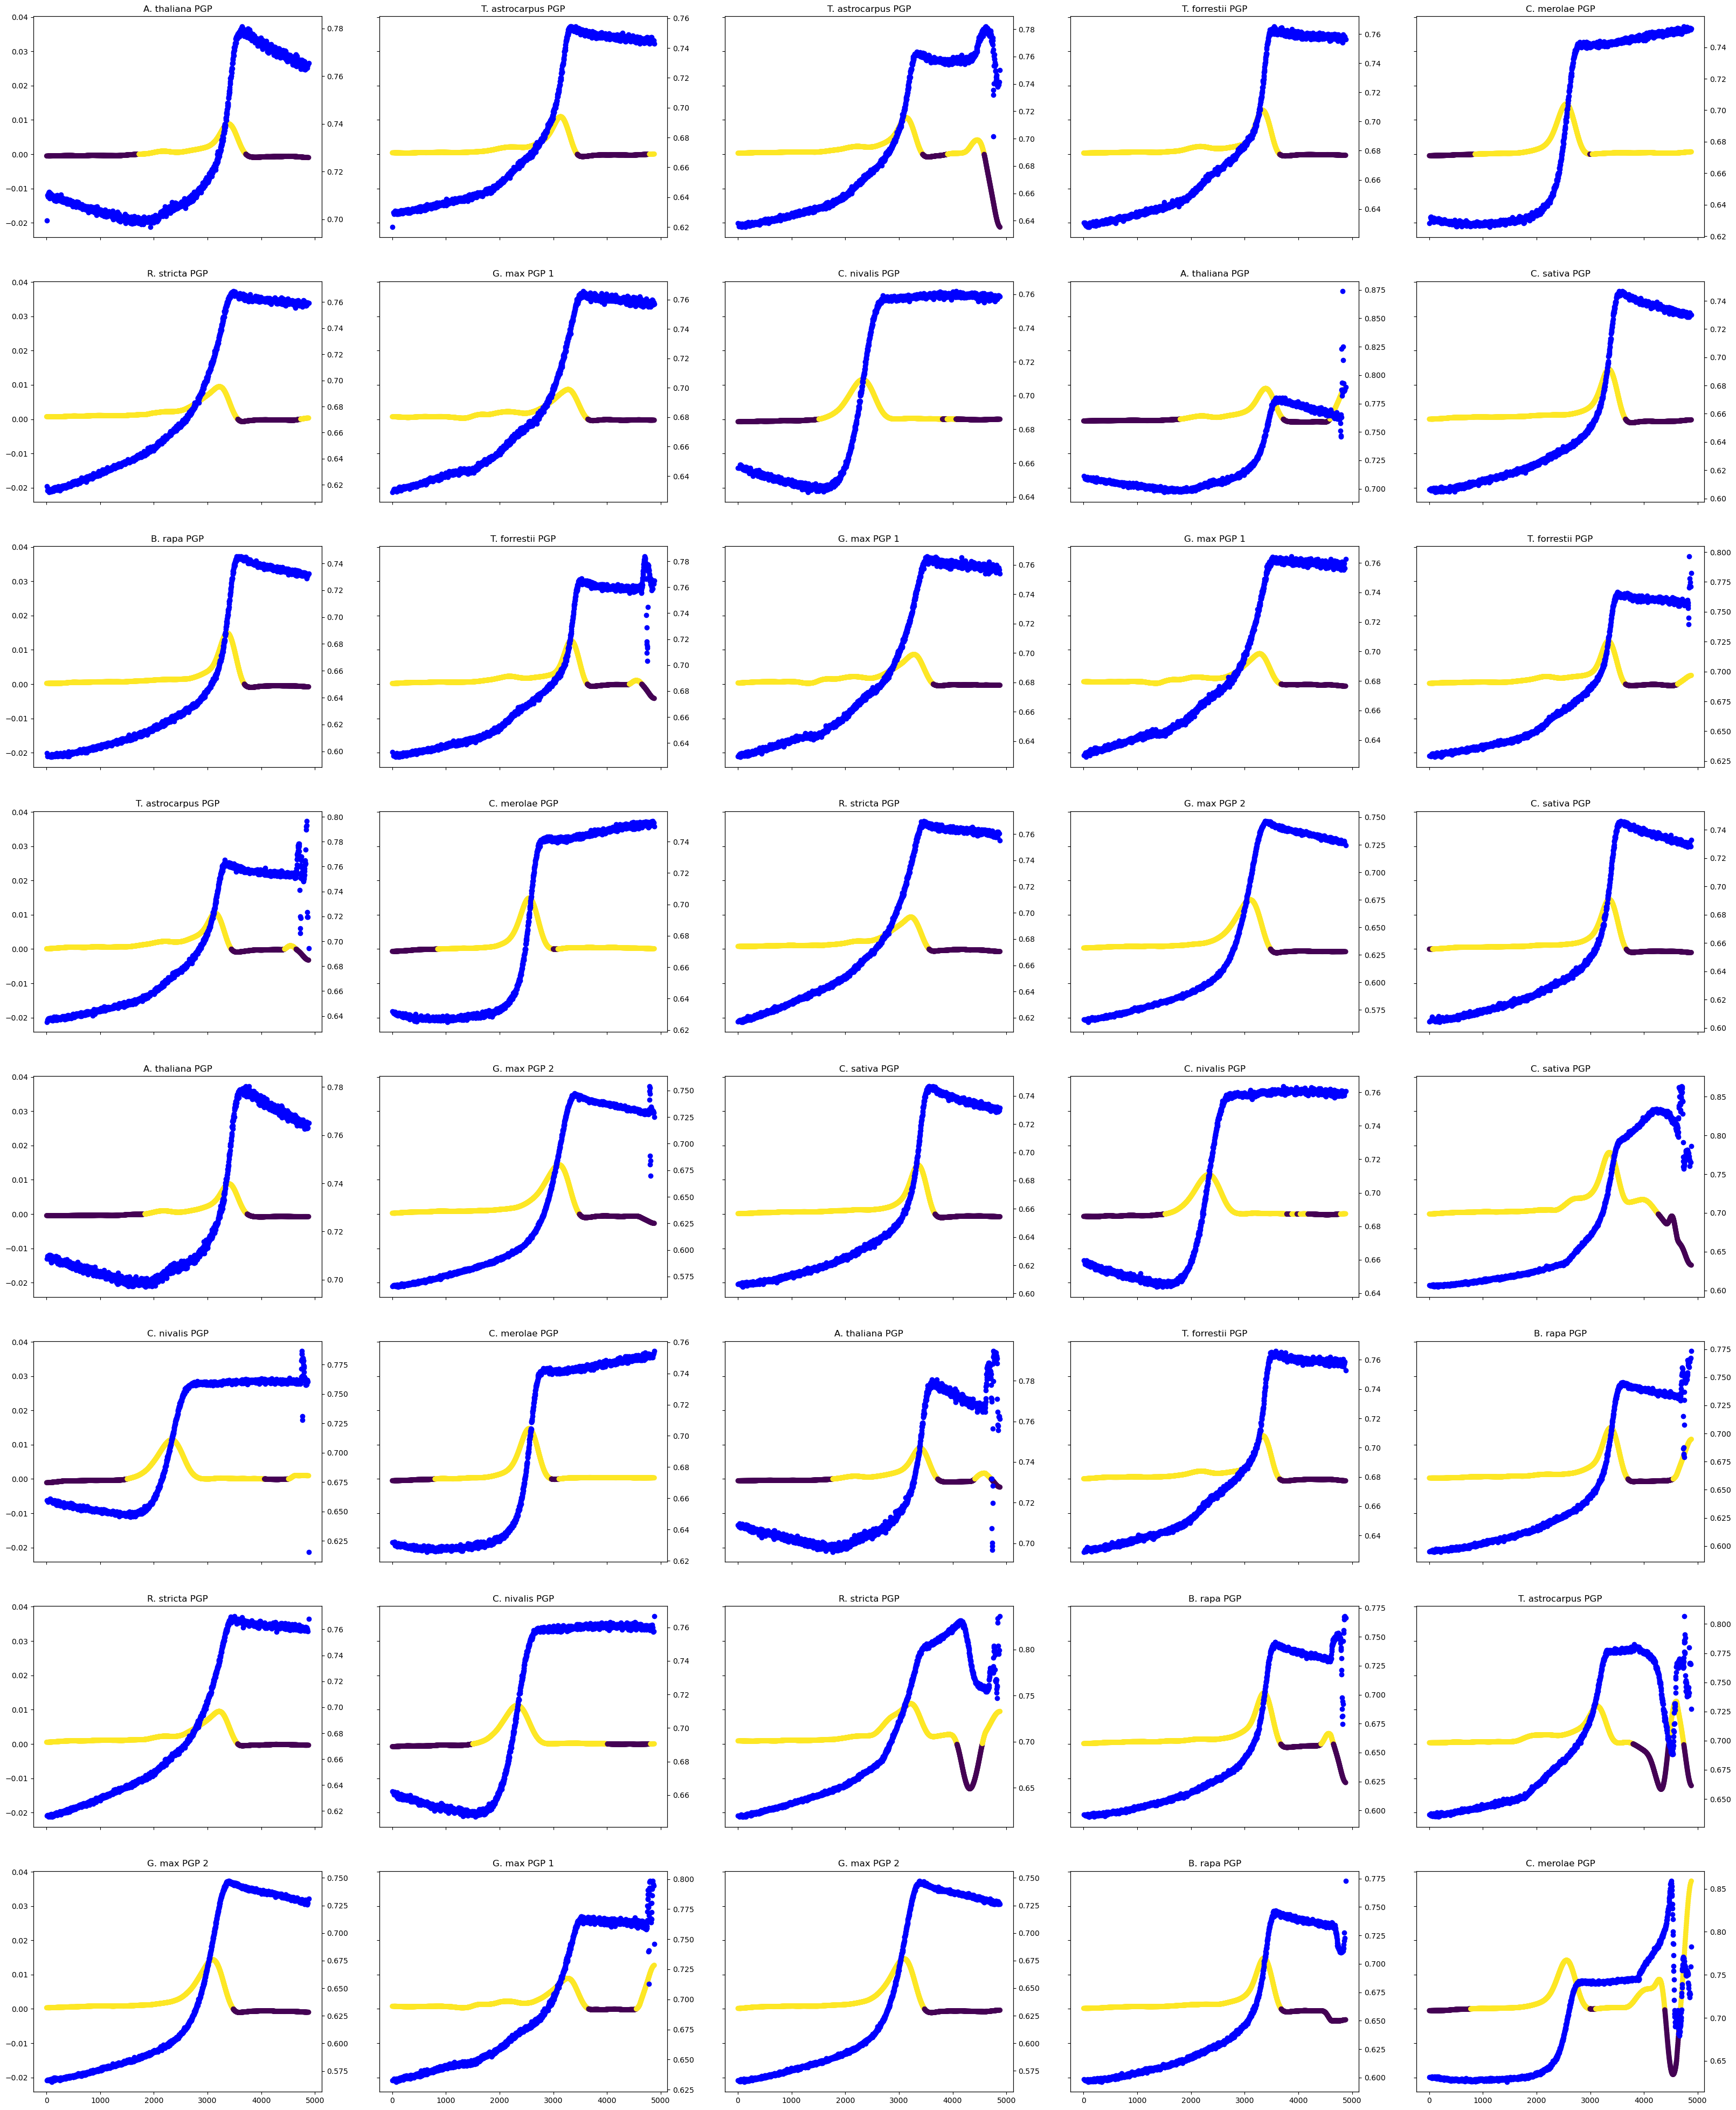

In [22]:
ratio_df = moltenprot_dfs['Ratio']
ratio_1st_der = moltenprot_dfs['Ratio (1st deriv.)']

num_species = ratio_df.shape[1] - 1
rows, cols = almost_factors(num_species)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(5*rows, 10*cols))

for col, colder, ax in zip(ratio_df.columns.tolist()[1:], ratio_1st_der.columns.tolist()[1:], axs.flat):

    ax.set_title(col[1])
    ax.scatter(ratio_1st_der.index, ratio_1st_der[colder], c=ratio_1st_der[colder] > 0, label='First derivative')
    ax1 = ax.twinx()
    ax1.scatter(ratio_df.index, ratio_df[col], color='blue', label='Ratio')

As a general rule of thumb, the messy parts begin where thefirst derivative has been first potive, then negative, then becomes positive again. What happens if we cut off all the curves there?

In [8]:
def cut_curve(index, curve, first_der):
    """
    Remove the remainder of the curve after the second positive transition of the first derivative.

    parameters:
        index, list: points on the x axis
        curve, list: points in the curve
        first_der, list: points in the first derivative

    returns:
        index_cut, list: index, cut at the second positive transition
        curve_cut, list: curve, cut at the second positive transition
        first_der_cut, list: first_der, cut at the second positive transition
    """
    start_is = '+'
    num_sign_trans_allow = 2
    num_sign_trans_done = 0
    for i, point in enumerate(first_der):
        # Allow curves to start with negative first derivatives
        if i == 0:
            if point < 0:
                start_is = '-'
                num_sign_trans_allow = 3
        # Start looking for sign transitions
        try:
            if point*first_der[i+1] < 0: # Means next point transitions
                num_sign_trans_done += 1
                if num_sign_trans_done == num_sign_trans_allow:
                    cut_point = i
                    break
        except IndexError: # Means it doesn't need to be cut
            cut_point = i - 1
    return index[:cut_point + 1], curve[:cut_point + 1], first_der[:cut_point + 1]

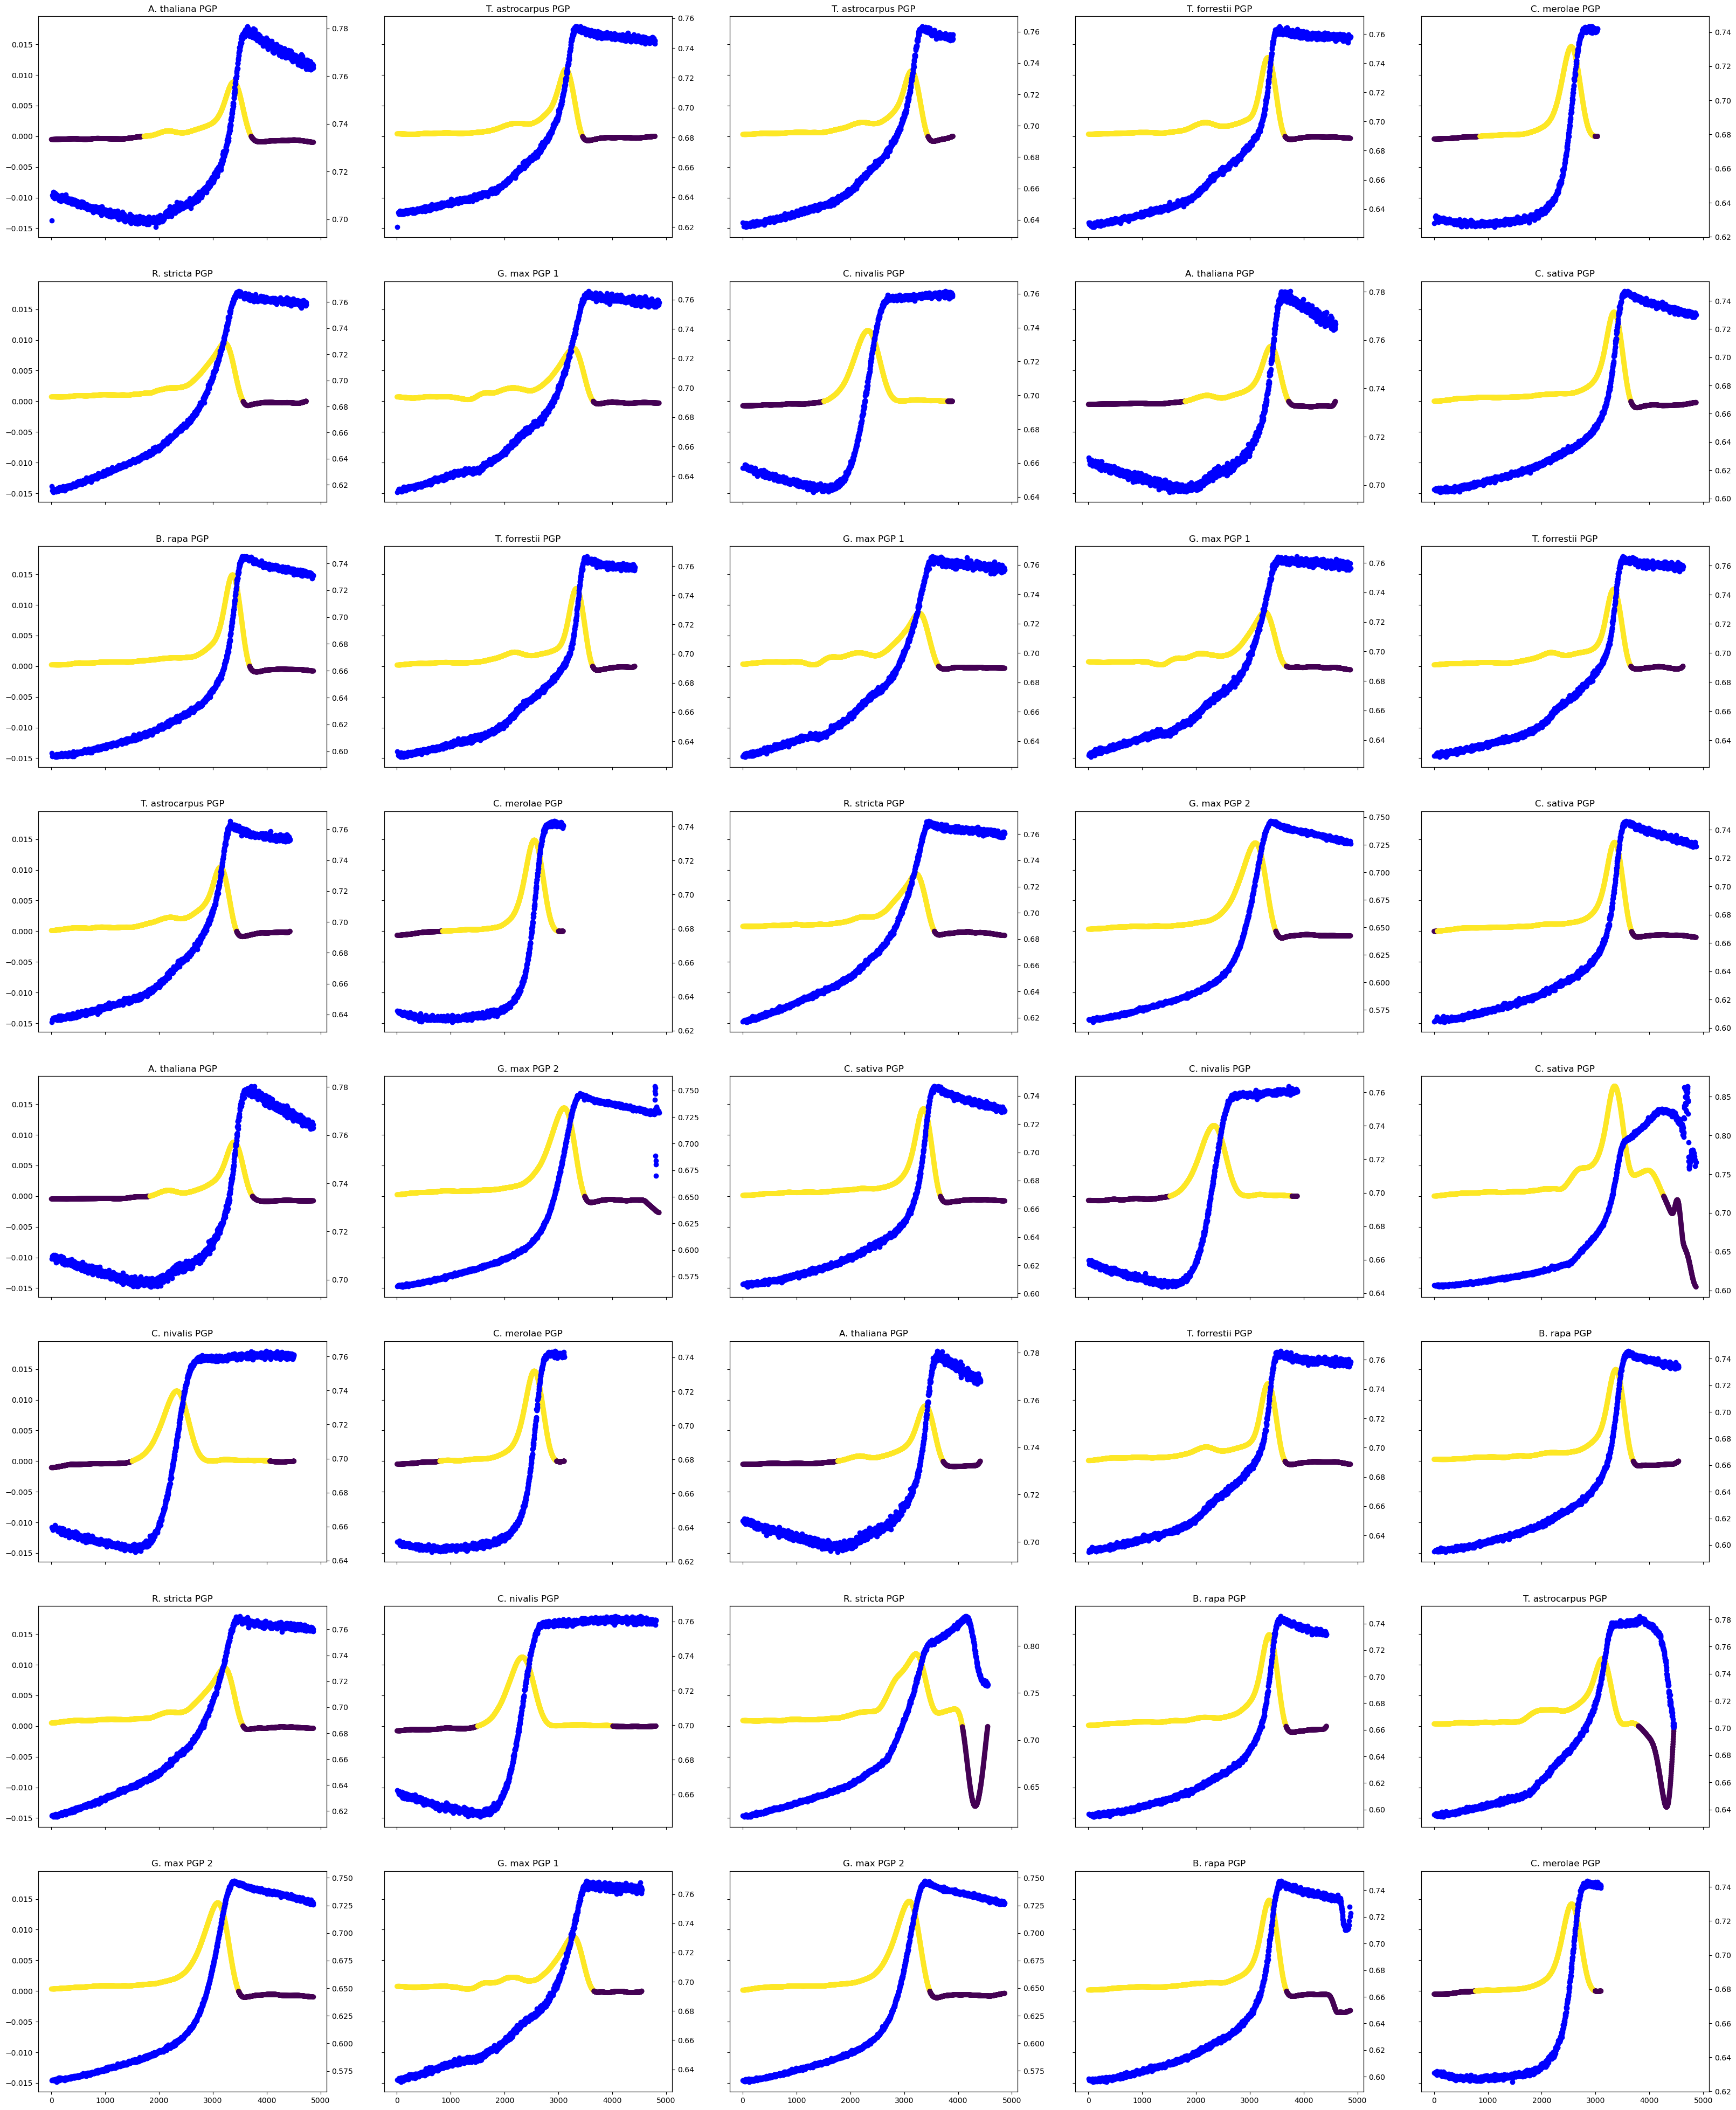

In [9]:
ratio_df = moltenprot_dfs['Ratio']
ratio_1st_der = moltenprot_dfs['Ratio (1st deriv.)']

num_species = ratio_df.shape[1] - 1
rows, cols = almost_factors(num_species)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(5*rows, 10*cols))

for col, colder, ax in zip(ratio_df.columns.tolist()[1:], ratio_1st_der.columns.tolist()[1:], axs.flat):

    ax.set_title(col[1])
    index_cut, curve_cut, first_der_cut = cut_curve(ratio_1st_der.index.tolist(), ratio_df[col].tolist(), ratio_1st_der[colder].tolist())
    ax.scatter(index_cut, first_der_cut, c=np.array(first_der_cut) > 0, label='First derivative')
    ax1 = ax.twinx()
    ax1.scatter(index_cut, curve_cut, color='blue', label='Ratio')

This almost works! There are a few edge cases it doesn't catch, but I think these can be addressed with one other criteria: the deviation from the y-value of the last positive point in the first derivative. It would be more thorough to use the second derivative; however, I tested the numerical derivation methods implemented in numpy and scipy, and neither was able to recreate the first derivative from the ratio curve in any approximation, so I don't believe it's safe to use it for the second derivative. Instead, I'm going to try using a deviation of 0.0025 from the last positive value, and see where that gets us.

In [18]:
def cut_curve_w_deviation(index, curve, first_der):
    """
    Remove the remainder of the curve after the second positive transition of the first derivative, plus
    any sections that go more than 0.025 above/below the last positive value.

    parameters:
        index, list: points on the x axis
        curve, list: points in the curve
        first_der, list: points in the first derivative

    returns:
        index_cut, list: index, cut at the second positive transition
        curve_cut, list: curve, cut at the second positive transition
        first_der_cut, list: first_der, cut at the second positive transition
    """
    start_is = '+'
    num_sign_trans_allow = 2
    num_sign_trans_done = 0
    for i, point in enumerate(first_der):
        # Allow curves to start with negative first derivatives
        if i == 0:
            if point < 0:
                start_is = '-'
                num_sign_trans_allow = 3
        # Start looking for sign transitions
        try:
            if point*first_der[i+1] < 0: # Means next point transitions
                num_sign_trans_done += 1
                if num_sign_trans_done == num_sign_trans_allow:
                    cut_point = i
                    break
            else: # Check for the deviations
                if num_sign_trans_allow - num_sign_trans_done == 1: 
                    if abs(0 - point) > 0.002:
                        cut_point = i
                        break
        except IndexError: # Means it doesn't need to be cut
            cut_point = i - 1
    return index[:cut_point + 1], curve[:cut_point + 1], first_der[:cut_point + 1]

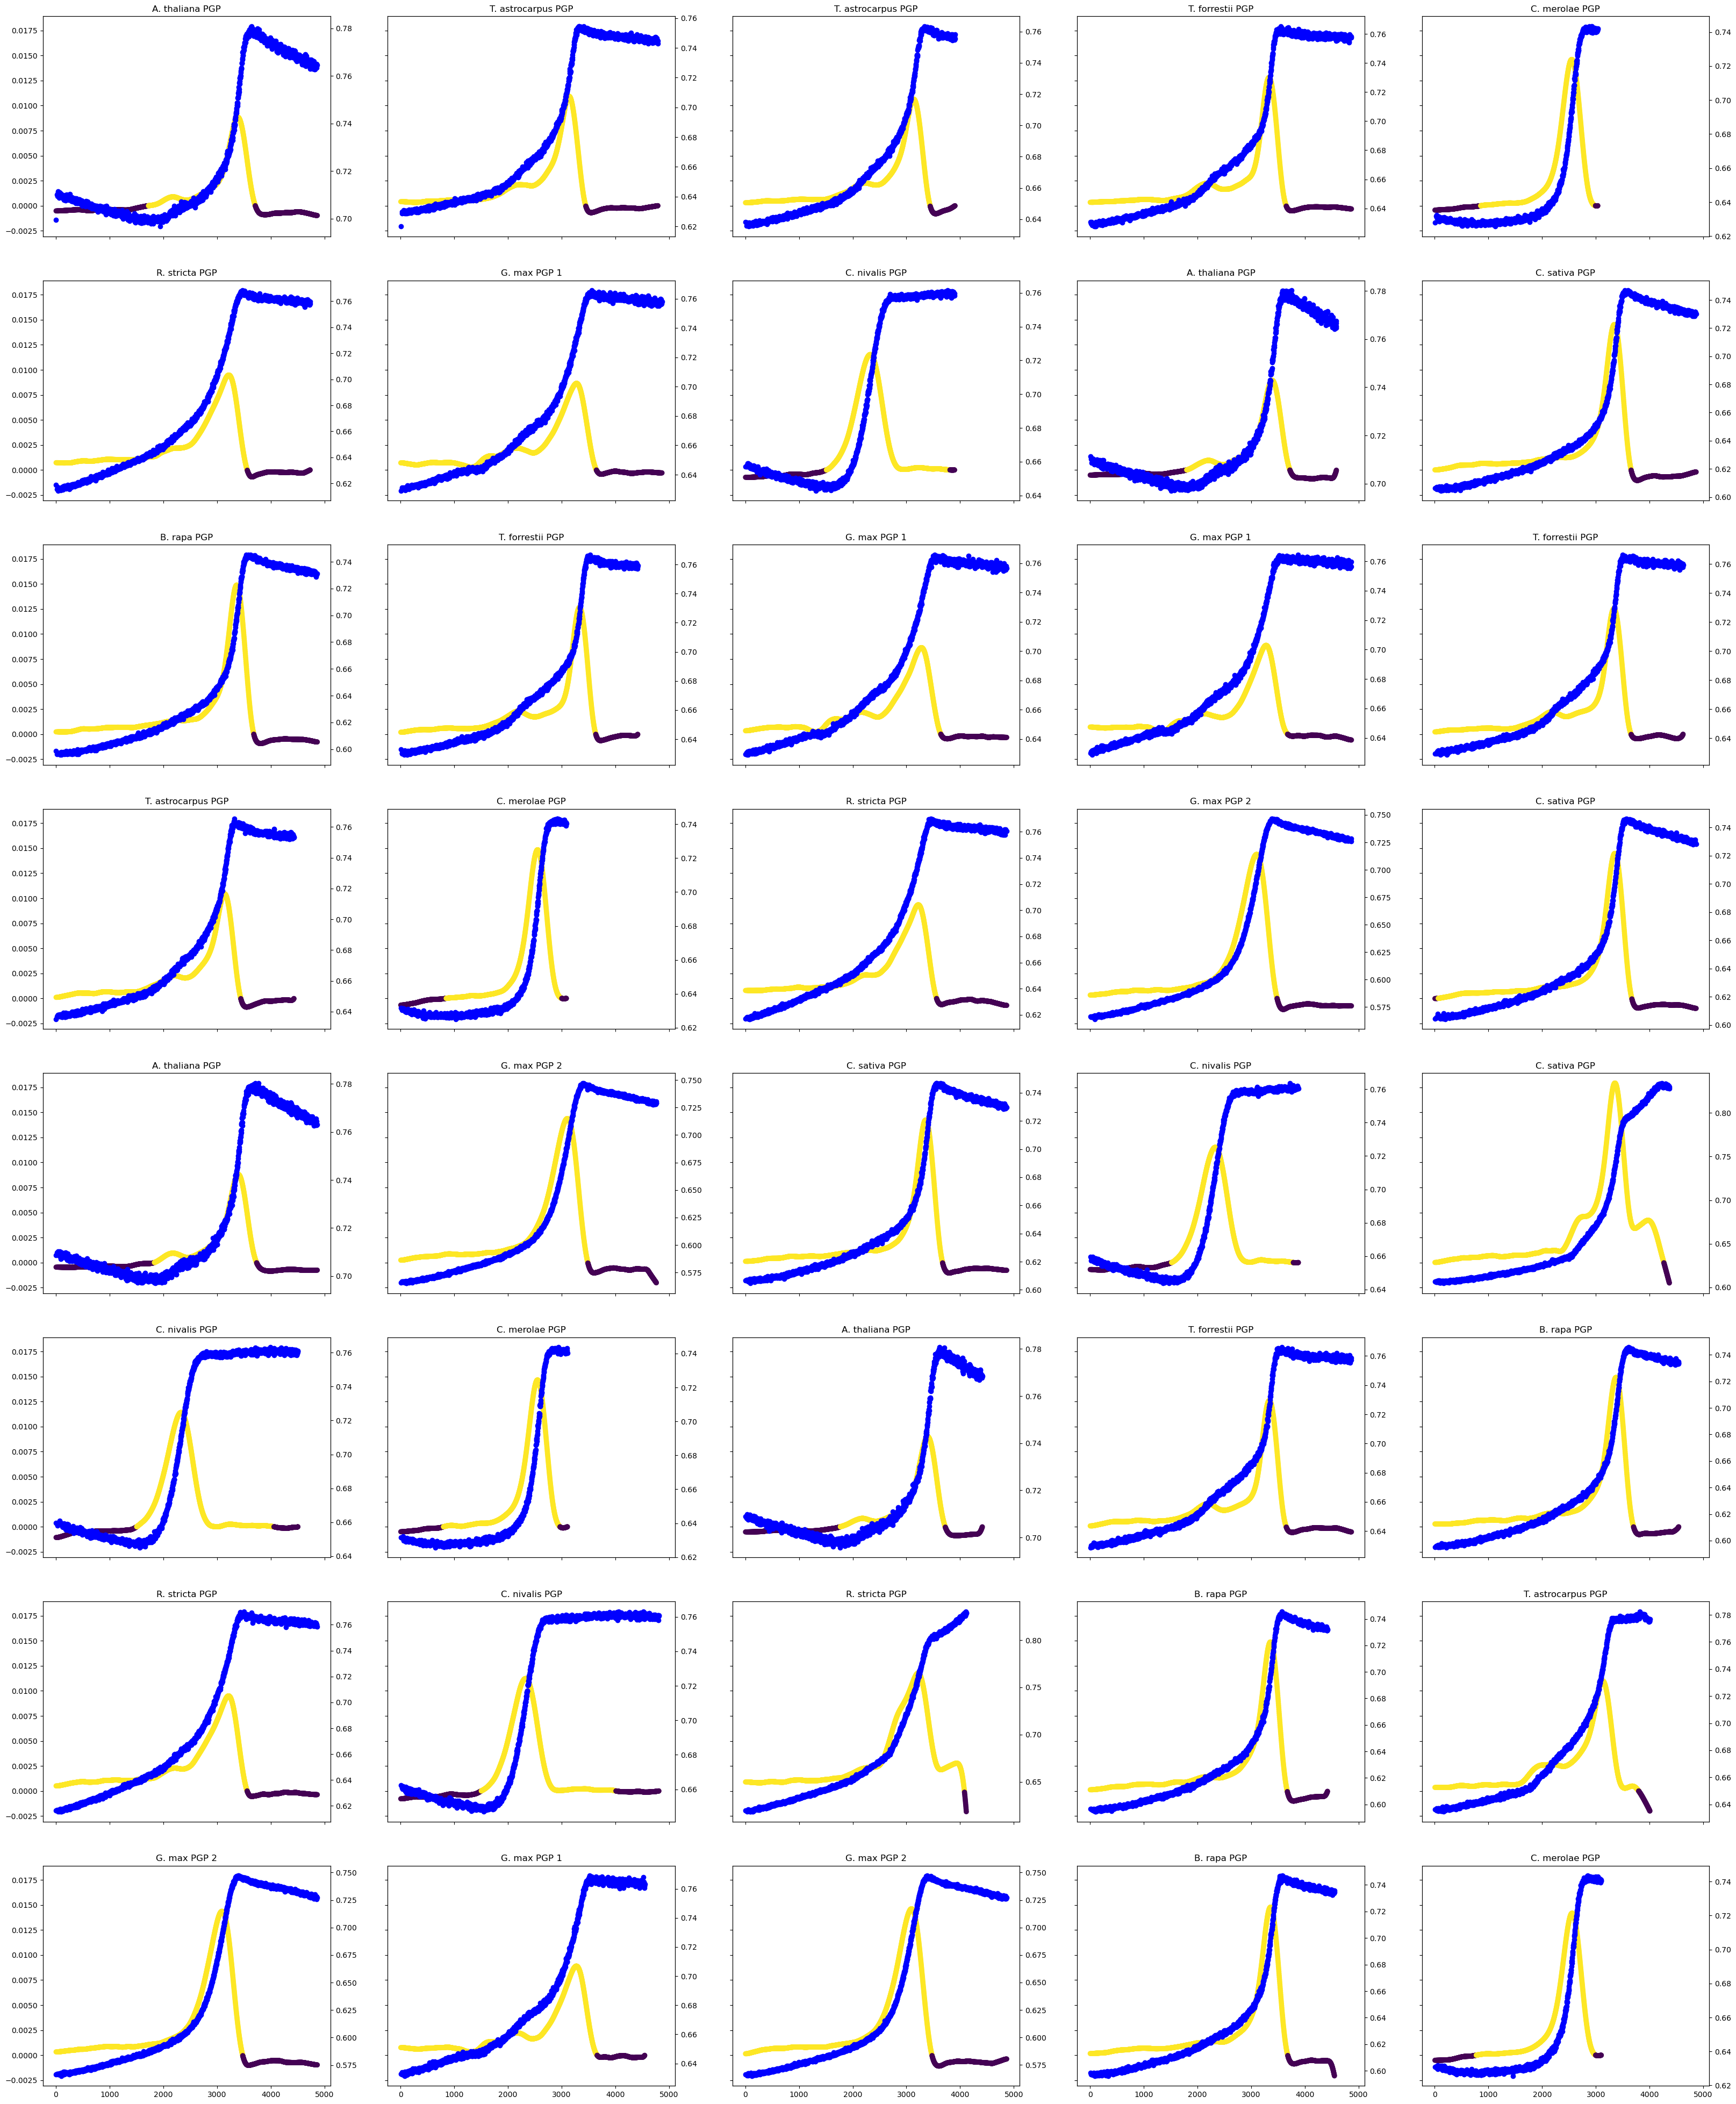

In [19]:
ratio_df = moltenprot_dfs['Ratio']
ratio_1st_der = moltenprot_dfs['Ratio (1st deriv.)']

num_species = ratio_df.shape[1] - 1
rows, cols = almost_factors(num_species)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(5*rows, 10*cols))

for col, colder, ax in zip(ratio_df.columns.tolist()[1:], ratio_1st_der.columns.tolist()[1:], axs.flat):

    ax.set_title(col[1])
    index_cut, curve_cut, first_der_cut = cut_curve_w_deviation(ratio_1st_der.index.tolist(), ratio_df[col].tolist(), ratio_1st_der[colder].tolist())
    ax.scatter(index_cut, first_der_cut, c=np.array(first_der_cut) > 0, label='First derivative')
    ax1 = ax.twinx()
    ax1.scatter(index_cut, curve_cut, color='blue', label='Ratio')

Looks like that works for this data! Going to make this into a script so that it can be run easily for new data.